# Signal and Image Processing (SIP_SS24)

### Research Group Neuroinformatics, Faculty of Computer Science,
### University of Vienna


###  Spectral estimation methods Tutorial

Lecturer: Prof. Moritz GROSSE-WENTRUP

Tutorial by: Jakob PRAGER 
$\quad\quad\quad\quad$ Kerim ATAK (kerim.atak@univie.ac.at)

#### Aim: implement several spectral estimation methods and test them on data from a BCI dataset

In the lecture we already discussed that it is not trivial how we estimate spectrum of a signal. The naive approach is to just apply a FFT and make a periodogram. The Periodogram however is a poor estimate, as it is prone to a high variance and spectral leakage. There are several ways of adressing these issues. Today we will take a look at:
##### 1. The naive approach <br>
##### 2. Applying a window <br>
##### 3. Bartlett's method <br>
##### 4. Welch's method <br>
##### 5. Multitapers <br>
and test their performance on data that was gathered for Brain computer interfaces (BCIs)

In [7]:
# import packages

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import scipy
import scipy.io as sio
import tensorflow as tf
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline


%matplotlib inline

## SSVEP dataset
SSVEP data is gatheres from subjects looking at flickering lights at different frequencies. By training a machine learning algorithm to detect the different frequencies one can build [visual keyboards](https://www.youtube.com/watch?app=desktop&v=gLVhplHu4Cs).
The dataset consists of data gathered from one subject looking at 20 different frequencies. One sample is 4 seconds long and has a sampling frequency of 250ms. To use it with BCIs, the goal could be to train a machine learning classifier to detect if certain frequencies are present in the frequency spectrum. If we want to follow this approach, we should create a fairly accurate depiction of the frequencies in the signal. With this in mind we will now implement different spectral estimation methods.

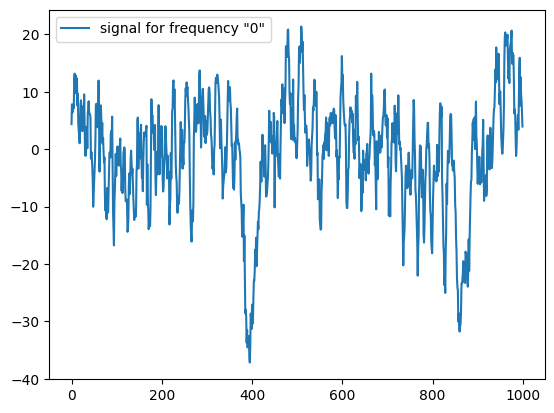

In [8]:
#load data
data_x = scipy.io.loadmat('tutorialdata.mat')['data']
data_y = np.argmax(scipy.io.loadmat('tutorialdata.mat')['labels'], axis=1)

# plot one sample signal of the SSVEP dataset
plt.plot(data_x[20], label=f'signal for frequency "{data_y[20]}"')
plt.legend()
plt.show()

# 1. No window
We don´t apply any spectral estimation methods and just create a periodogram

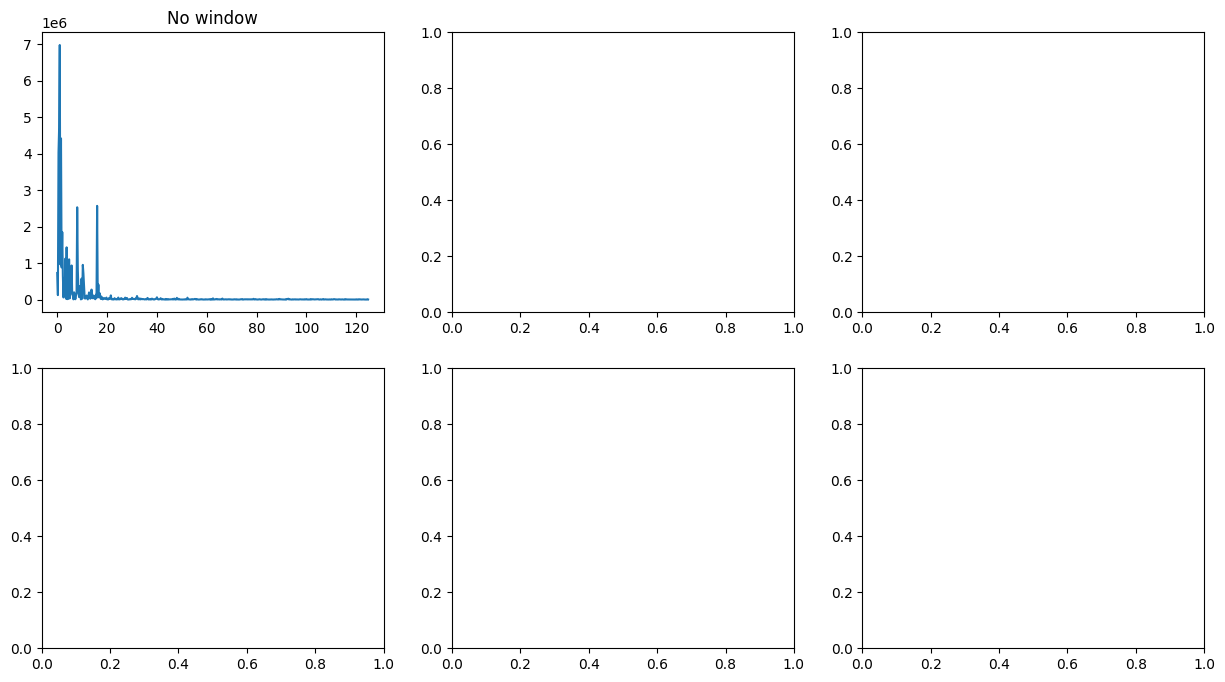

In [9]:
# make an FFT of all samples, take the absolute and square it
FFT_data_x = np.abs(np.fft.fft(data_x, axis = 1))**2

# take only half (for consistensy reasons)
FFT_data_x = FFT_data_x[:, :500]

# plot spectrum
freqs = np.arange(0,125, 0.25)
fig , ax = plt.subplots(2,3, figsize = (15,8))
ax[0,0].plot(freqs,FFT_data_x[20])
ax[0, 0].set_title('No window')
plt.show()

# 2. Using Windows
#### Now we can try to apply windows to the samples before making a periodogram. We use the function "scipy.signal.windows.get_window" to create the windows. You can get all possible windows on:
[link to scipy website](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.windows.get_window.html#scipy.signal.windows.get_window)

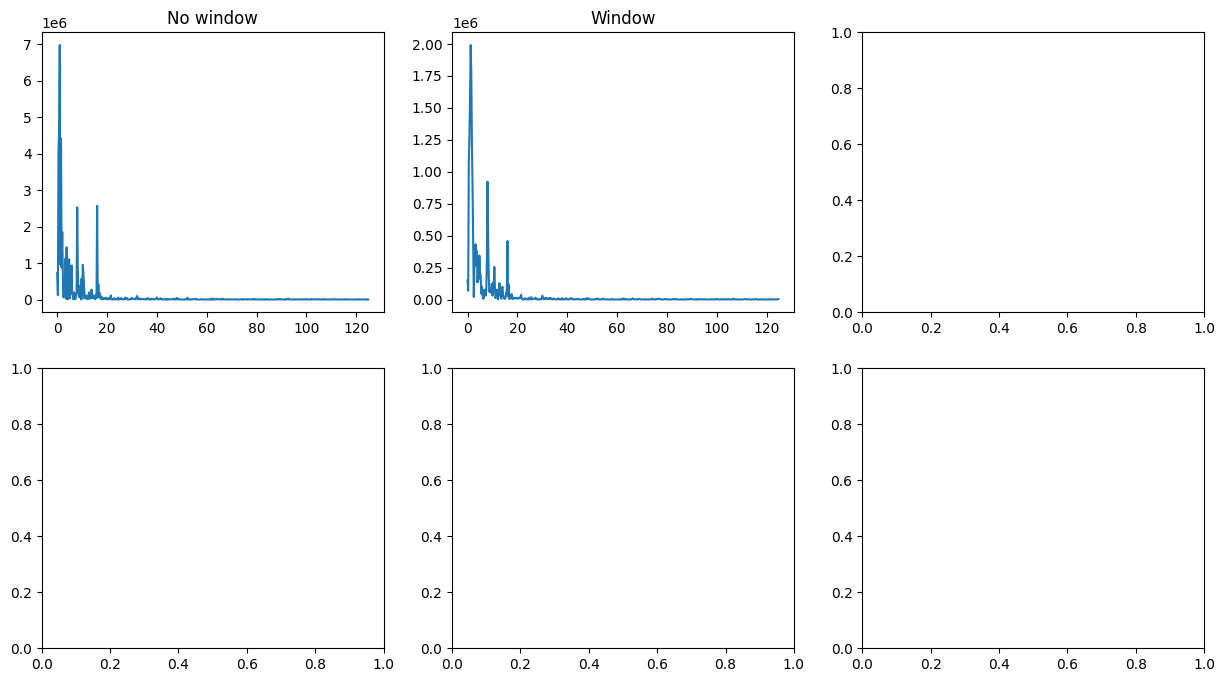

In [10]:
# create windows. Feel free to play around with the type of window used.
window = scipy.signal.get_window("hann", 1000)


# apply window to all samples
windowed_data = data_x * window

# create periodograms from windowed data
FFT_windowed = np.abs(np.fft.fft(windowed_data, axis = 1))**2

# take only half (for consistensy reasons)
FFT_windowed = FFT_windowed[:, :500]

# plot spectrum
freqs = np.arange(0,125, 0.25)
fig , ax = plt.subplots(2,3, figsize = (15,8))
ax[0,0].plot(freqs,FFT_data_x[20])
ax[0, 0].set_title('No window')
ax[0,1].plot(freqs,FFT_windowed[20])
ax[0, 1].set_title('Window')
plt.show()

# 3. Bartlett's method

Bartlett's method is a classical technique for estimating the power spectral density (PSD) of a random signal. It is based on dividing the signal into non-overlapping segments, applying a window function to each segment, and then averaging the squared magnitudes of the resulting Fourier transforms.


Bartlett's method is particularly useful when dealing with stationary signals, and it provides a simple and intuitive way to estimate the frequency content of a signal.

The PSD estimate using Bartlett's method is given by:

$$\hat{S_B}(w) \quad = \quad \frac{1}{N_1} \sum_{m = 1}^{N_1} \frac{1}{N_2}\Big(\sum_{n=1}^{N_2} x[n+mN_2] \cdot e^{-jwn}\Big)^2$$

(4, 120, 250)
(4, 120, 250)


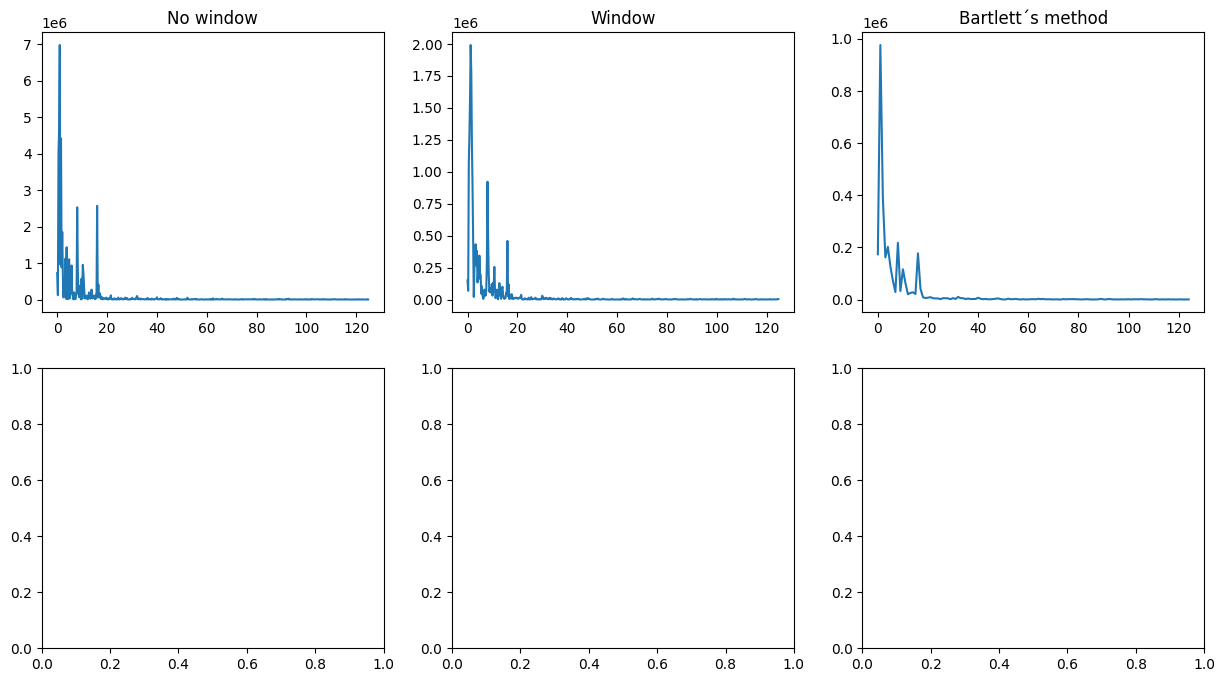

In [23]:
# for bartlett's method the variable is the split ratio. Feel free to play around with it and observe its performance.
splits = 4

# split data into equal sizes
splitted_data =  np.array(np.split(data_x, splits, axis= 1))
print(np.array(splitted_data).shape)
# make a FFT of each signal and square the absolute
periodogram = np.abs(np.fft.fft(splitted_data, axis = 2))**2
print(periodogram.shape)
# take the mean of the periodograms of the split signals
bartlett = np.mean(periodogram,axis=0)

# take only half for consistency reasons
bartlett = bartlett[:,:int(1000/splits/2)]

# plot spectra
freqs = np.arange(0,125, 0.25)
freqs_b = np.arange(0,125, 125/bartlett.shape[1])
fig , ax = plt.subplots(2,3, figsize = (15,8))
ax[0,0].plot(freqs,FFT_data_x[20])
ax[0, 0].set_title('No window')
ax[0,1].plot(freqs,FFT_windowed[20])
ax[0, 1].set_title('Window')
ax[0,2].plot(freqs_b,bartlett[20])
ax[0, 2].set_title('Bartlett´s method')
plt.show()

# 4. Welch´s method

Welch's method is a spectral estimation technique that improves upon Bartlett's method by introducing overlapping segments. This helps reduce the variance of the spectral estimate compared to Bartlett's method, especially when dealing with short data sequences.

Welch's method involves dividing the signal into overlapping segments, applying a window function to each segment, computing the periodograms, and then averaging them to obtain a smoother and more reliable estimate of the power spectral density.

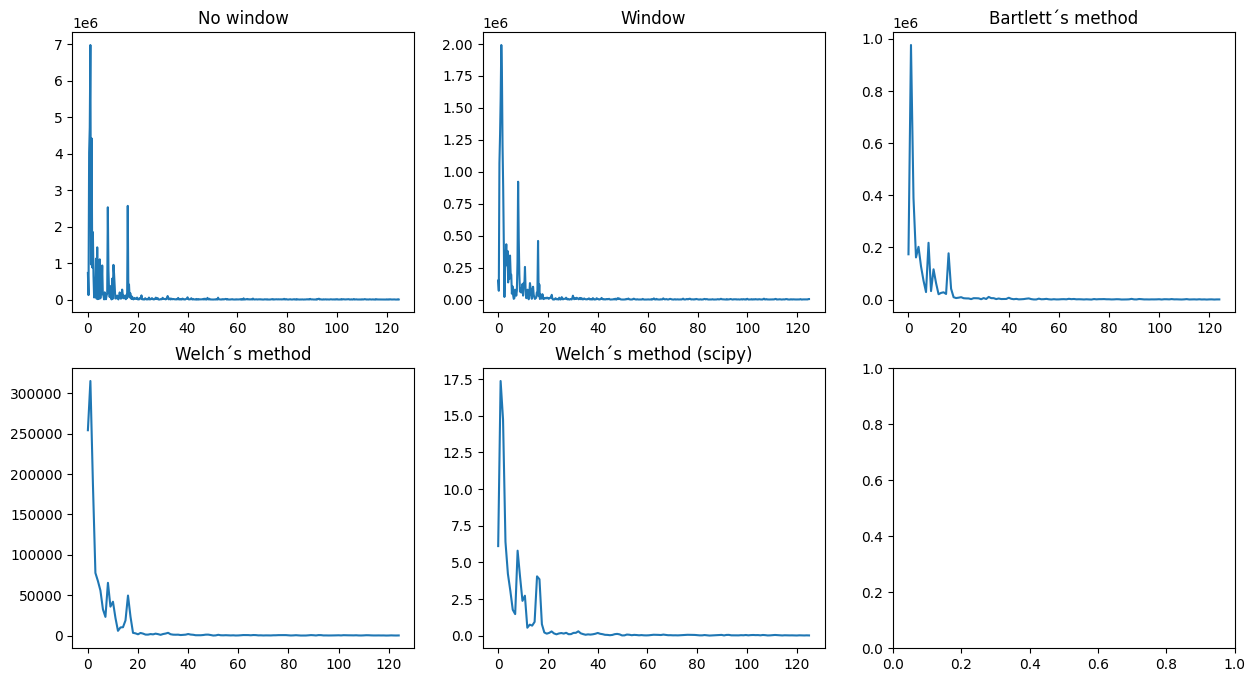

In [12]:
# welch´s method is a bit more complicated to implement, so we create a function
def welch_method_by_hand(x, y): # y: split length
    welch = []
    for array in x:
        splits = []
        # Calculate the overlap size
        overlap = y // 2
        # Iterate to create n splits
        for i in range(y):
            start = i * (y - overlap)
            end = start + y
            # Ensure that the end index does not exceed the array length
            if end > len(array):
                break
            splits.append(array[start:end])
        #apply a window and create a periodogram
        window = scipy.signal.get_window("hann", y)
        windowed_data = splits * window
        periodogram = np.abs(np.fft.fft(windowed_data))**2

        # take the mean of the periodograms of the split signals
        welch.append(np.mean(periodogram,axis=0))

    return np.array(welch)

# feel free to play around with the length of the splits
split_length = 250
Welch_FFT = welch_method_by_hand(data_x, split_length)

# furthermore, we can test the scipy version of welchs method
f, welch_FFT_2 = scipy.signal.welch(data_x, fs = 250)

#take half for consistency reasons
Welch_FFT= Welch_FFT[:,:split_length//2]

#plot all spectral estimations up to now
fig , ax = plt.subplots(2,3, figsize = (15,8))
freqs = np.arange(0,125, 0.25)
freqs_b = np.arange(0,125, 125/bartlett.shape[1])
freqs_w = np.arange(0,125, 125/Welch_FFT.shape[1])
ax[0,0].plot(freqs,FFT_data_x[20])
ax[0, 0].set_title('No window')
ax[0,1].plot(freqs,FFT_windowed[20])
ax[0, 1].set_title('Window')
ax[0,2].plot(freqs_b,bartlett[20])
ax[0, 2].set_title('Bartlett´s method')
ax[1,0].plot(freqs_w,Welch_FFT[20])
ax[1, 0].set_title('Welch´s method')
ax[1,1].plot(f,welch_FFT_2[20])
ax[1, 1].set_title('Welch´s method (scipy)')
plt.show()


# 5. Multitapers
Multitaper is a time-frequency decomposition (spectral density estimation) method different from Short-Time Fourier Transform (STFT), Wavelet convolution, and Filter Hilbert methods. These three (3) methods, have similar procedures but with different applications. Multitaper differs from these three, but gives approximately the same result. Multitapers smooth signals over frequency and time.

#### The aim is to design a set of optimal windows, such that we can smooth or average the  signal spectrum over a bandwidth of $2w_{s}$ which serves as the constraint for our optimization problem.

$$\big|X(w)\big| \quad = \quad \frac{1}{k} \sum_{k = 1}^{K} \Big|\sum_{n=-\frac{N}{2}}^{\frac{N}{2}} w[k] \cdot x[k] \cdot e^{(-jwn)}\Big|$$

<br>
Visual depiction of multitapers

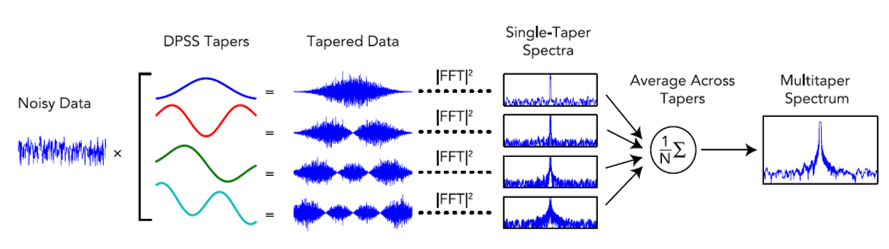

Adapted from [Multitaper toolbox](https://github.com/preraulab/multitaper_toolbox)



# To compute the multitapers

The expression is a simple multiplication of a window $w[n]$ with our signal $x[n]$; however, the window must be the same length as the original signal.

$$x[n] \cdot w[n]$$



### Parameters

Assuming a signal/window size $w$ ranging from $\left[-\frac{N}{2}, \dots, \frac{N}{2}\right]$, The length of the signal/window is then given as `N+1`.

$w_{s}$ is the allowable bandwidth/threshold at which the multitaper can smoothen our spectrum

$A$ measures the energy concentration of the multitapers

$$\sum_{n=-\frac{N}{2}}^{\frac{N}{2}}\sum_{m=-\frac{N}{2}}^{\frac{N}{2}} \frac{2sin \left(w_{s}(m - n\right))}{m - n}$$

Recall, the solution to the optimization problem is given as
$$A.\vec{w} = \lambda^{'} \vec{w}$$

With matrix decomposition:
$$\vec{w^{T}}A\vec{w} = \lambda^{'}\vec{w^{T}}\vec{w} = \lambda^{'}$$

C:\Users\kerim\AppData\Local\Temp\ipykernel_8356\4059951368.py:11: RuntimeWarning: invalid value encountered in divide
  A = 2 * np.sin(w_s * (n[:,None] - m[None,:])) / (n[:,None] - m[None,:])


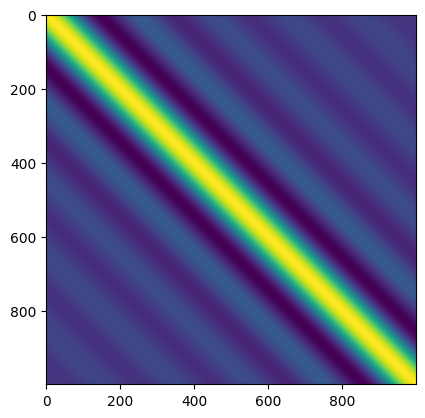

In [13]:
# let N be 1000 in this case

N = 1000
w_s = 0.01*np.pi  # here we selected an allowable threshold of 0.1, this will be tuned afterwards

m = np.arange(N)
n = np.arange(N)

# np.expand_dims(n, (1))) of n

A = 2 * np.sin(w_s * (n[:,None] - m[None,:])) / (n[:,None] - m[None,:])

np.fill_diagonal(A,2* w_s)
plt.imshow(A)


We filled the diagonals of $A$ with $2w_{s}$ because we encountered some zero division error every time n == m.

To solve this, we need to fill it with the limit of the function as n approaches m using [$\textbf{L'Hôpital's rule}$](https://en.wikipedia.org/wiki/L%27H%C3%B4pital%27s_rule).

Recall from the lecture, we constrained our optimization function with $2w_{s}$

Compute eigenvectors

#### Hint: we use np.linalg.eigh(A) because it gives the eigenvectors sorted according to their respective eigenvalue

The eigenvalue plot will enable us to determine the number of eigenvalues that will be useful for selecting eigenvectors (multitapers) for our use.

We are only interested in those multitapers corresponding to eigenvalues with very high energy concentrations. In simple terms, selecting those eigenvectors means we only consider multitapers with the highest energy concentration.

For the sake of demonstration, I defined a variable `count` as the number of eigenvalues selected and plotted them in red color.

#### Note: You can toy around with the choice of `count`.

In [14]:
eig_values, eig_vectors = np.linalg.eigh(A)

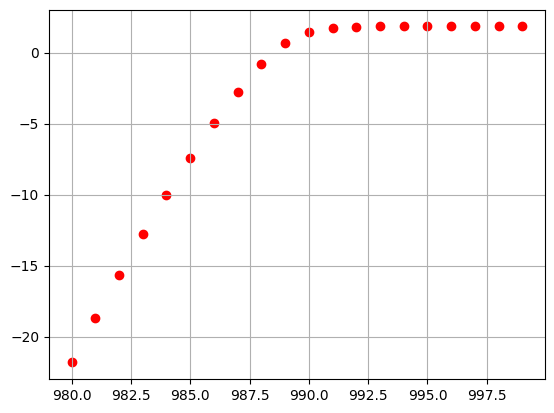

In [15]:
count = 20

# plot the number of eigenvalues selected and observe their values
plt.scatter(range(N - count, N), np.log(np.abs(eig_values[-count:])), color='red')
plt.grid()

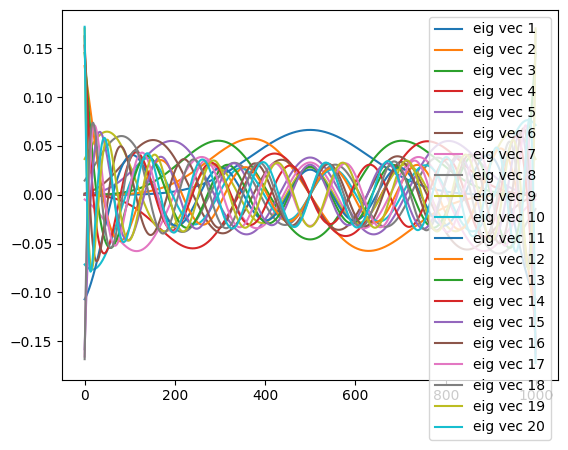

In [16]:
# plot eigen vecors
for i in range(1,count+1):
    plt.plot(eig_vectors[:,-i],label=f'eig vec {i}')
    plt.legend()

From the plot, we can see that the multitapers are orthogonal and mutually uncorrelated to one another. The first multitaper (with only the first eigenvector) looks precisely Gaussian, and the second one appears as a derivative of the first, and so on. These are not coincidences but rather show the orthogonality of the multitapers. All the individual orthogonal multitapers will then work together as a sequence. The aim is that each of these multitapers will capture or highlight different features in the data.

Now, we can check the efficiency of our selected number of multitapers by taking the Fourier Transform as described below. The efficiency is measured by how the overall multitaper approximates a rectangular window.

$$|X(w)| = \frac{1}{K} \sum_{k = 1}^{K} \Big|\sum_{n=-\frac{N}{2}}^{\frac{N}{2}} w_k[n] \cdot x[n] \cdot e^{(-jwn)}\Big|$$



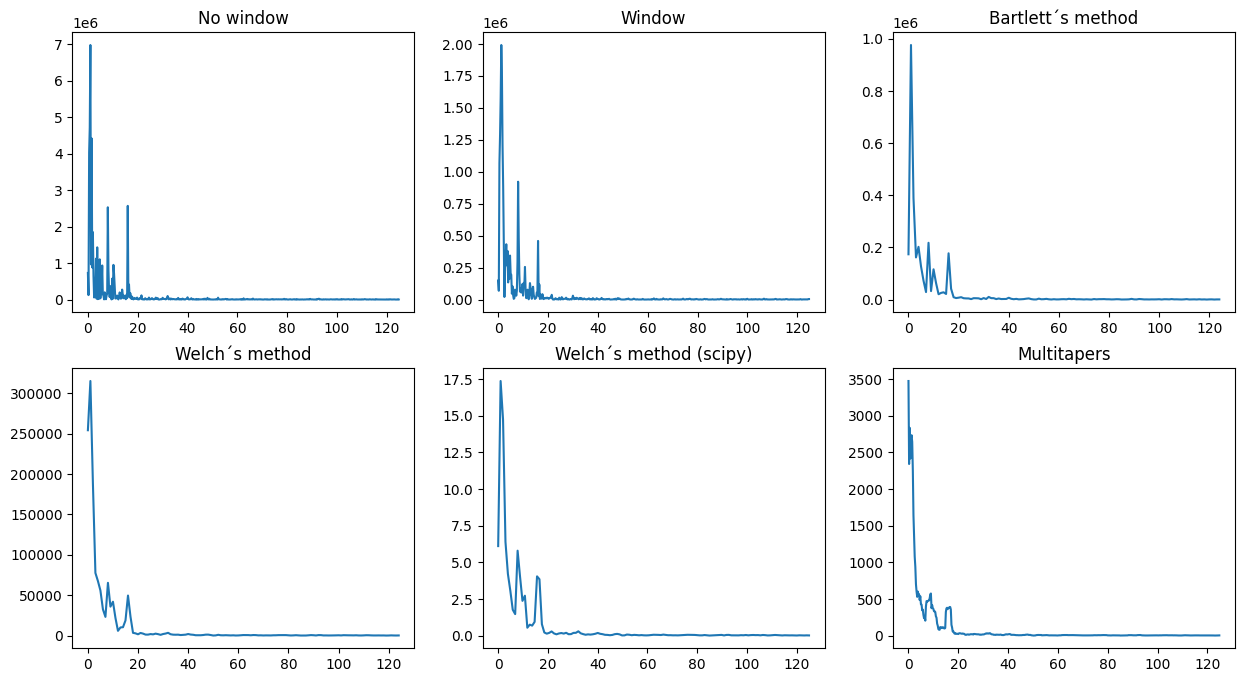

In [26]:
#from scipy.fft import fft, fftfreq, ifft
FFTs = []

# loop over eigenvectors to multiplicate them with the data
# you can change the number of tapers used by changing the range
for x in range(1,10):
     FFTs.append(np.abs(np.fft.fft(data_x*eig_vectors[:,-x],axis=1))**2)
FFTs = np.array(FFTs)

# take the mean of all tapers
tapered_FFT = np.mean(FFTs, axis=0)

# take only half for consistency reasons
tapered_FFT = tapered_FFT[:,:500]

# plot all spectral estimations up to now
fig , ax = plt.subplots(2,3, figsize = (15,8))
freqs = np.arange(0,125, 0.25)
freqs_b = np.arange(0,125, 125/bartlett.shape[1])
freqs_w = np.arange(0,125, 125/Welch_FFT.shape[1])
ax[0,0].plot(freqs,FFT_data_x[20])
ax[0, 0].set_title('No window')
ax[0,1].plot(freqs,FFT_windowed[20])
ax[0, 1].set_title('Window')
ax[0,2].plot(freqs_b,bartlett[20])
ax[0, 2].set_title('Bartlett´s method')
ax[1,0].plot(freqs_w,Welch_FFT[20])
ax[1, 0].set_title('Welch´s method')
ax[1,1].plot(f,welch_FFT_2[20])
ax[1, 1].set_title('Welch´s method (scipy)')
ax[1,2].plot(freqs,tapered_FFT[20])
ax[1, 2].set_title('Multitapers')
plt.show()

# Test performance of spectral estimation
We can now train a support vector classifier (SVC) for each spectral estimation method and test how well it can predict unseen data.

In this case we use a SVC for the sake of simplicity. While a CNN might perform better generally, we don´t need to achieve perfect classification accuracy but want to explore the differences between spectral estimation techniques.

('No window', 0.375)
('Window', 0.35)
('multitapers', 0.475)
('bartletts method', 0.55)
('welchs method', 0.525)
('welch(sicpy)', 0.5)


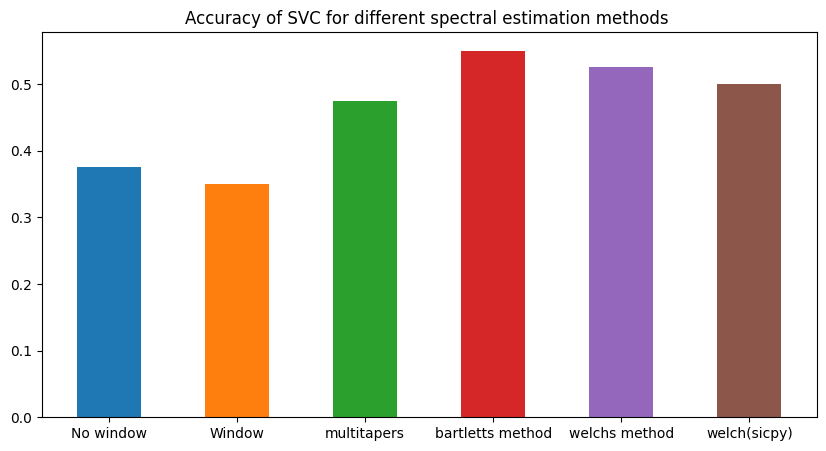

In [18]:
# create a library to iterate over them
methods = {"No window":FFT_data_x,"Window":FFT_windowed,"multitapers" :tapered_FFT,  'bartletts method' : bartlett, "welchs method" :Welch_FFT,"welch(sicpy)" :welch_FFT_2}

#initialize figure for plotting
plt.figure(figsize=(10,5))
plt.title('Accuracy of SVC for different spectral estimation methods ')

#iterate over all methods and train a SVC on the samples
for method in methods:
    # split data into train and test data
    X_train, X_test, y_train, y_test = train_test_split(methods[method], data_y, test_size=0.33, random_state=42)
    # we scale the data and train a SVC
    pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])
    pipe.fit(X_train, y_train).score(X_test, y_test)
    score = pipe.set_params(svc__C=10).fit(X_train, y_train).score(X_test, y_test)

    #print results
    print((method, score))
    #visualize results
    plt.bar(method,score, width=0.5)


